In [2]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [3]:
# Load the data frames

log_pr = pd.read_pickle("./log_price.df")
volu = pd.read_pickle("./volume_usd.df")
# look at the dataset
#log_pr.head()
# Check the log-prices of the 10 assets
#log_pr.plot(figsize=(12, 8))

# Pre-processing
# Differencing log prices to obtain stationary series
#log_pr_diff = log_pr.diff()
#log_pr_diff.plot(figsize=(12, 8))

In [4]:
log_pr.shape
volu.shape

(264960, 10)

In [13]:
log_pr_sta = log_pr.diff().iloc[1:,]
log_pr_sta.mean(0)

0    7.731425e-07
1   -3.588131e-06
2    6.897168e-06
3   -5.620517e-08
4   -1.729424e-06
5   -1.641189e-06
6   -9.379338e-07
7   -1.684068e-06
8    1.984488e-07
9   -3.675100e-07
dtype: float64

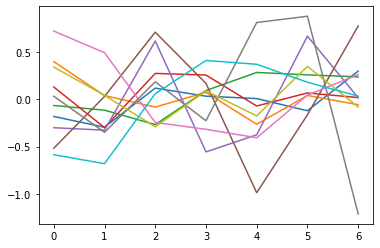

In [14]:
from statsmodels.tsa.stattools import ccf
for i in range(10):
    plt.plot(ccf(log_pr_sta.iloc[:10000:1440,i], volu.diff().iloc[1:10000:1440,i]))

there seems to have some strong cross-correlation in one day within a week

### Check volatility computed every 30 mins

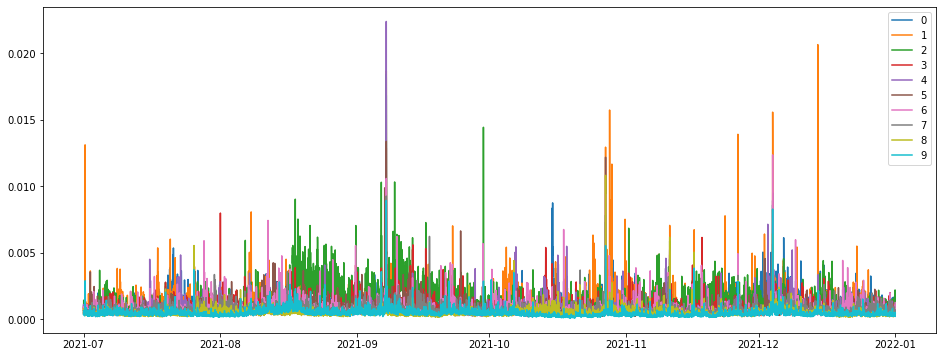

In [262]:
volatility = log_pr_sta.resample('30T').std()
plt.figure(figsize=(16,6))
for i in range(10):
    plt.plot(volatility[i], label='{}'.format(i))
plt.legend()

it is clear there are clusters, especially evident for stock 2 and 

Text(0.5, 1.0, 'Correlation Heatmap for Volatility')

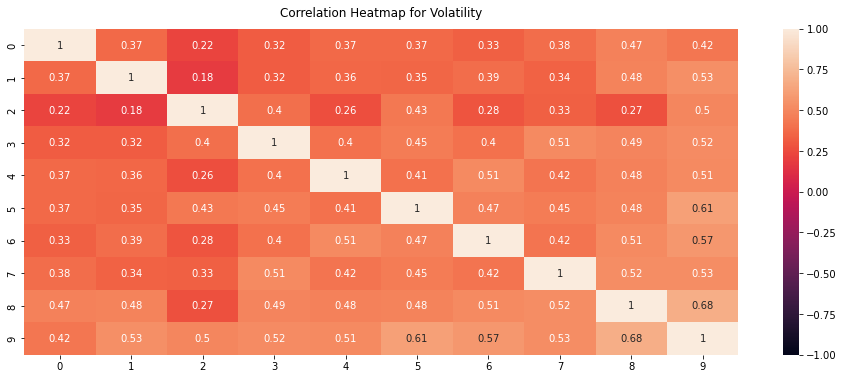

In [8]:
# plot correlation heatmap for the volatility
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(volatility.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap for Volatility', fontdict={'fontsize':12}, pad=12)

We see strong correlation for every stock with 8 & 9. 3,4,5,6,7

### Check correlation of volume and volatility

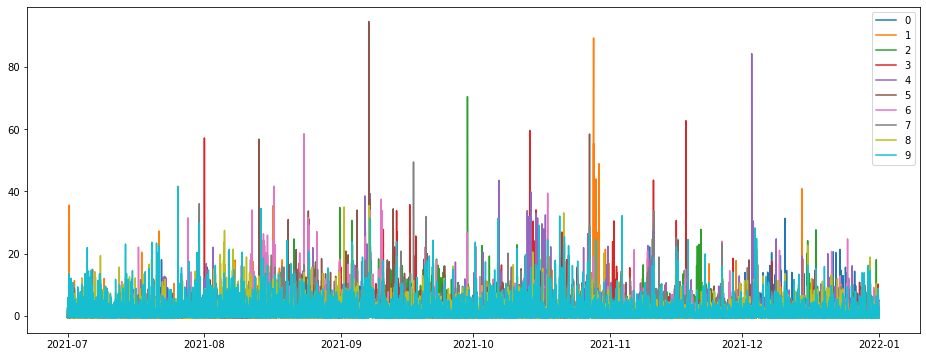

In [9]:
std_volu = (volu-volu.mean())/volu.std()

plt.figure(figsize=(16,6))
for i in range(10):
    plt.plot(std_volu[i], label='{}'.format(i))
plt.legend()
    

Text(0.5, 1.0, 'Correlation Heatmap for Volatility')

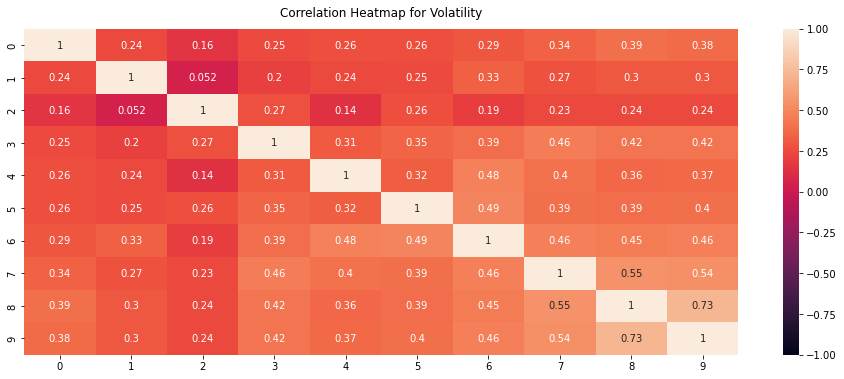

In [11]:
# plot cross correlation heatmap for the 30 mins volatility and standardised volume
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(std_volu.iloc[30:,:].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap for Volatility', fontdict={'fontsize':12}, pad=12)

### Check volatility using squared stationary log return

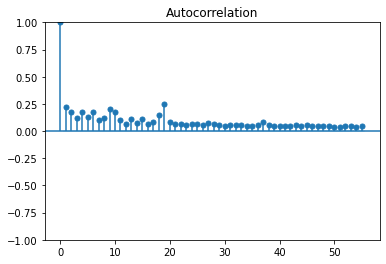

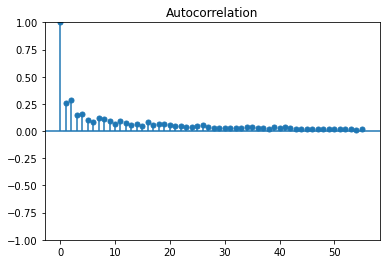

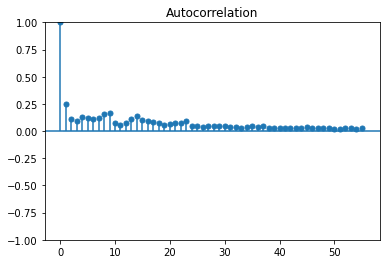

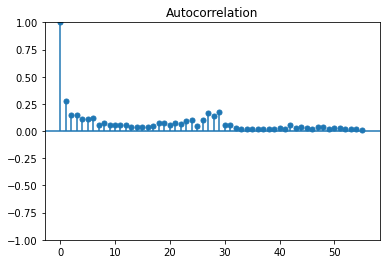

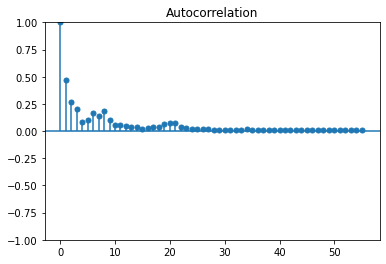

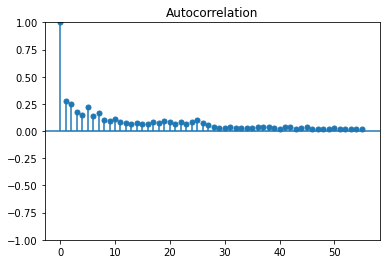

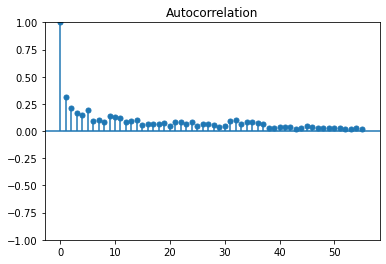

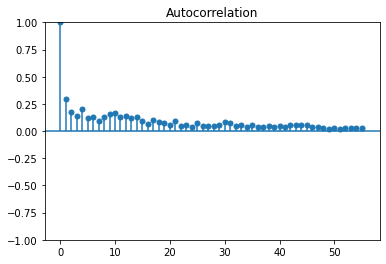

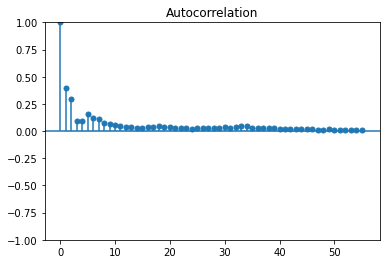

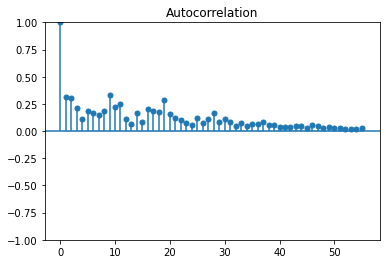

In [15]:
# # Resampling data
# log_pr_10 = log_pr.resample("10T").mean()
from statsmodels.graphics.tsaplots import plot_acf
for i in range(10):
    plot_acf(log_pr.diff().iloc[1:, i]**2)

# Feature Engineering

In [26]:
import statsmodels.api as sm
from statsmodels.multivariate.pca import PCA
from statsmodels.multivariate.factor import Factor
from statsmodels.graphics.tsaplots import plot_acf

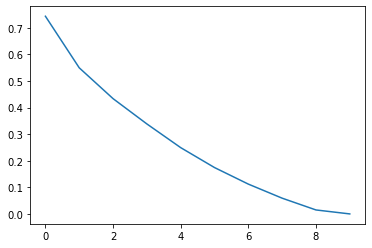

In [19]:
# stationary log return
pca_model1 = PCA(log_pr_sta.iloc[:10000,], standardize=False, demean=False)
score = pca_model1.eigenvals.cumsum()/pca_model1.eigenvals.sum()
plt.figure()
plt.plot(1-score)
plt.show()

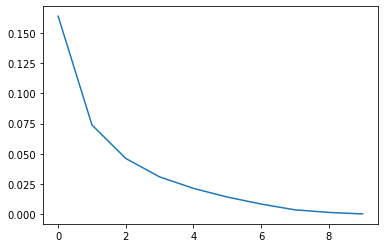

In [24]:
# 30 mins window volatility
from statsmodels.multivariate.pca import PCA
pca_model2 = PCA(volatility.iloc[:10000,], standardize=False, demean=False)
score = pca_model2.eigenvals.cumsum()/pca_model2.eigenvals.sum()
plt.figure()
plt.plot(1-score)
plt.show()

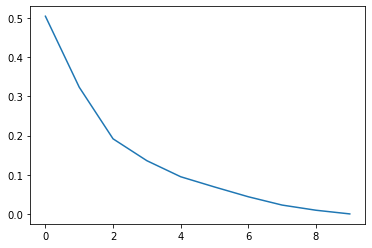

In [25]:
# standardised volume 
from statsmodels.multivariate.pca import PCA
pca_model3 = PCA(std_volu.iloc[1:10000,], standardize=False, demean=False)
score = pca_model3.eigenvals.cumsum()/pca_model3.eigenvals.sum()
plt.figure()
plt.plot(1-score)
plt.show()

In [9]:


# two groups (1,2,4,7) and (0,5,6,8) and two alone 3 & 9
# group1 = log_pr[[1,2,4,7]]
# group2 = log_pr[[0,5,6,8]]
# stock1 = log_pr[3]
# stock9 = log_pr[9]

# group1 = [2, 4, 6]
# group2 = [7, 8, 9]
# group3 = [1]
# group4 = [3]
# group5 = [5]

### Remove Outliers
remove outliers (setting their value to missing), defined as observations that are more than 10 times the interquartile range from the series mean. 
Notably from the above plot, there is a stock market crash at the beginning of september. This should be removed, since it is not useful signal. The outliers are set as NaN missing values, which can be taken care of in the Dynamic Factor Model.

In [27]:
def remove_outliers(dta):
    # Compute the mean and interquartile range
    mean = dta.mean(0)
    iqr = dta.quantile([0.25, 0.75], axis=0).diff().T.iloc[:, 1]
    
    # Replace entries that are more than 10 times the IQR
    # away from the mean with NaN (denotes a missing entry)
    mask = np.abs(dta) > mean + 10 * iqr
    treated = dta.copy()
    treated[mask] = np.nan

    return treated

The following is to find the minutely difference for volume (to match minutely difference of log_return)

In [187]:
dta_pr = log_pr_sta
dta_volu = volu.diff().iloc[1:,]

In [129]:
print(dta_pr.shape)
print(volatility.shape)
print(dta_volu.shape)

(264959, 10)
(264929, 10)
(264959, 10)


We then compute the rolling mean and std of log return and volume. Note that this is effectively smoothing the data. Since the rolling window used for the judge is move forward every 10 mins to compute r_hat, the resolution works out, but we can also take 30 mins (since prediction is 30mins forward). Below also shows, volatility with different resolution (alternative is 30 mins). But I feel taking mean is better than resampling.

In [263]:
dta_pr_10 = dta_pr.resample('10T').mean().iloc[10:,]
dta_vol_10 = dta_pr.resample('10T').std().iloc[10:,] # volatility
dta_volu_10 = dta_volu.resample('10T').mean().iloc[10:,]
dta_volu_std_10 = dta_volu.resample('10T').std().iloc[10:,]

dta_pr_30 = dta_pr.resample('30T').mean().iloc[30:,]
dta_vol_30 = dta_pr.resample('30T').std().iloc[30:,] # volatility
dta_volu_30 = dta_volu.resample('30T').mean().iloc[30:,]
dta_volu_std_30 = dta_volu.resample('30T').std().iloc[30:,]

<AxesSubplot:xlabel='timestamp'>

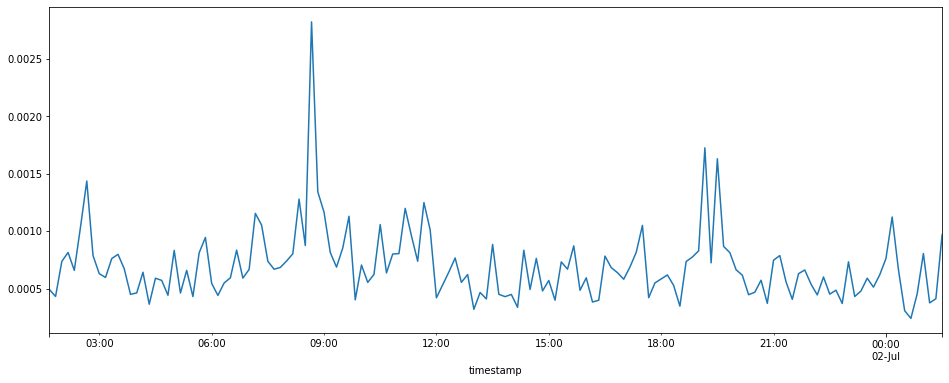

In [266]:
(dta_vol_10).iloc[:144,0].plot(figsize=(16,6))

<AxesSubplot:xlabel='timestamp'>

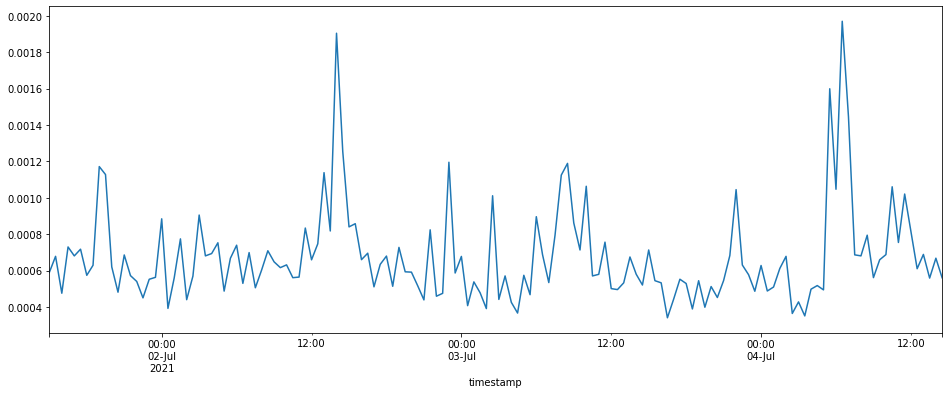

In [267]:
(dta_vol_30).iloc[:144,0].plot(figsize=(16,6))

Standardise the mean by deviding the std.

In [268]:
dta_pr_std = remove_outliers(dta_pr_30/dta_vol_30)
dta_volu_std = remove_outliers(dta_volu_30/dta_volu_std_30)

<AxesSubplot:xlabel='timestamp'>

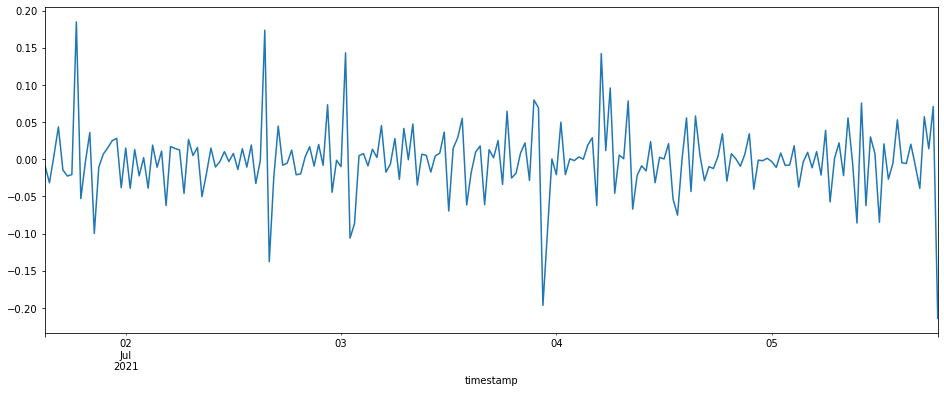

In [269]:
# volume
(dta_volu_std).iloc[:200,0].plot(figsize=(16,6))

It is not evident that the volume is useful for predicting log_return, at least for 30 mins resolution. Perhaps, we can directly fit a time series model (e.g. MA with Lag < 5, check below for acf) to the log return. 

I tried to compute the cross correlation, however, it doesn't seem to work...

In [ ]:
# plot correlation heatmap for the volatility
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dta_pr_std.corrwith(dta_volu_std), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap for Volatility', fontdict={'fontsize':12}, pad=12)

### Check Volatility

<AxesSubplot:xlabel='timestamp'>

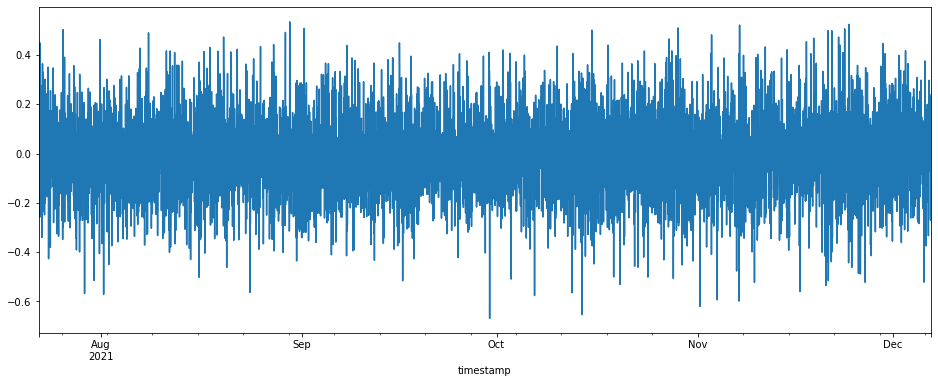

In [288]:
# log return
dta_pr_std.iloc[1000:-1200,0].plot(figsize=(16,6))

<AxesSubplot:xlabel='timestamp'>

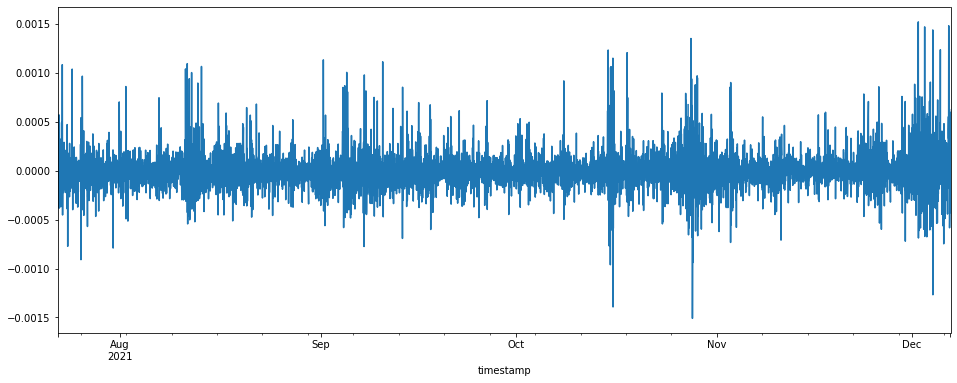

In [287]:
# before standardised
remove_outliers(dta_pr_30).iloc[1000:-1200:,0].plot(figsize=(16,6))

Perhaps we can directly fit a volatility model, e.g. GARCH, GARCH SVM (which also includes a mean component if I recall correctly? then the lag should be no more than 5, perhaps, 2 or 3).

### We check the acf again

seems lag < 5

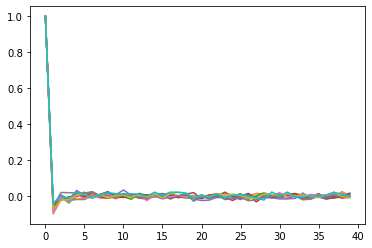

In [274]:
from statsmodels.tsa.stattools import acf
for col in range(10):
    plt.plot(acf(dta_pr_std[col], missing='drop'))


### Rolling OLS 
Predict log return with volume. Doesn't seem to work well. But we could code a function to predict every forward prediction.

In [276]:
from statsmodels.regression.linear_model import OLS
from statsmodels.regression.rolling import RollingOLS


exog = sm.add_constant(dta_volu_std[0])
endog = dta_pr_std[0]

rols = RollingOLS(endog, exog, window=48)
rres = rols.fit()
params = rres.params.copy()
params.index = np.arange(1, params.shape[0] + 1)


In [277]:
eff_params = params[48:]

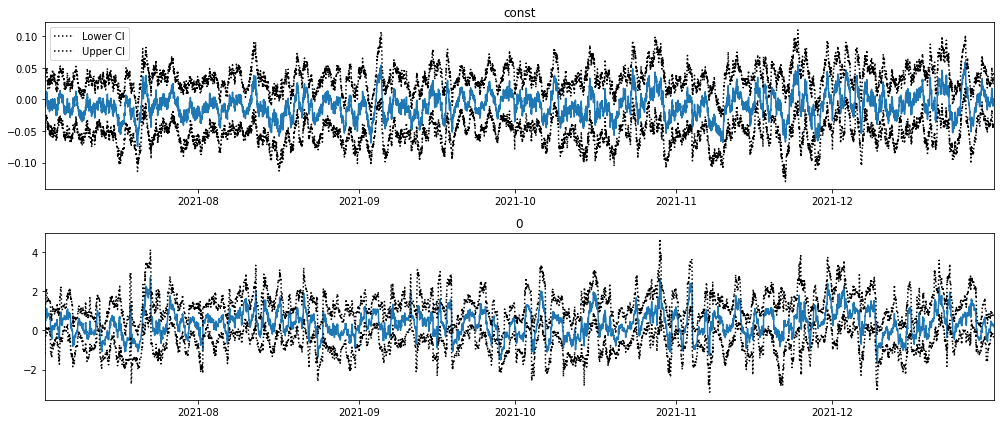

In [278]:
fig = rres.plot_recursive_coefficient(variables=["const", 0], figsize=(14, 6))


In [289]:

exog = sm.add_constant(dta_volu_std[0]).iloc[:48,]
endog = dta_pr_std[0].iloc[:48,]

eff_params.iloc[0]

lm = OLS(endog, exog)
pred = lm.predict(params=eff_params.iloc[0], exog = sm.add_constant(dta_volu_std[0]).iloc[48:52,])

In [290]:
pred

array([ 0.00351655, -0.02692748,  0.02715704,  0.00755518])

In [295]:
dta_pr_std[0][48:52]

timestamp
2021-07-02 15:00:00    0.033563
2021-07-02 15:30:00    0.128435
2021-07-02 16:00:00   -0.396060
2021-07-02 16:30:00   -0.090206
Freq: 30T, Name: 0, dtype: float64

the first prediction is pretty close tho... But the rest is not.

### Some Archive

In [86]:
# group = ['group1'] * len(group1) + ['group2'] * len(group2) + ['group3'] + ['group4']
# dta = dta_log_pr.copy().T
# dta['group'] = group

In [87]:
# dta.groupby('group').count().T

### DFM Model fitting

Now we need to specify all the details of the specific dynamic factor model that we want to estimate. In particular, we will choose:
Factor specification, including: how many factors to include, which variables load on which factors, and the order of the (vector) autoregression that the factor evolves according to.
Whether or not to standardize the dataset for estimation.
Whether to model the idiosyncratic error terms as AR(1) processes or as iid.

In [21]:
# # Factor Model

# fa_model1 = Factor(group1,n_factor=1)
# fa_model2 = Factor(group2,n_factor=1)

In [22]:
# # Dynamic Factor Model

# from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
# dfm1 = DynamicFactor(dta_log_pr.iloc[10000:20000, group1],k_factors=2,factor_order=10)
# dfm2 = DynamicFactor(dta_log_pr.iloc[10000:20000, group2],k_factors=2,factor_order=10)

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


In [215]:
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
dfm1 = DynamicFactor(dta_pr_std.iloc[:1440*2,:], k_factors=7, factor_order=3, error_order=1)

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


In [216]:
initial_res = dfm1.fit(method='powell', disp=False)
res = dfm1.fit(initial_res.params, disp=False)

KeyboardInterrupt: 

In [181]:
point_forecasts = res.forecast(steps=4)
print(point_forecasts)


                            0         1         2         3         4  \
2021-07-05 00:02:00  0.000402  0.000333 -0.000633 -0.000181  0.000154   
2021-07-05 00:12:00 -0.000067 -0.000033 -0.000019 -0.000167  0.000029   
2021-07-05 00:22:00 -0.000335  0.000248  0.000042  0.000264 -0.000023   
2021-07-05 00:32:00  0.000128  0.000190 -0.000053 -0.000112  0.000034   

                            5         6         7         8         9  
2021-07-05 00:02:00  0.000031 -0.000073  0.000104 -0.000143 -0.000341  
2021-07-05 00:12:00 -0.000041  0.000058 -0.000015  0.000295  0.000373  
2021-07-05 00:22:00  0.000084 -0.000123  0.000044 -0.000228 -0.000340  
2021-07-05 00:32:00 -0.000092 -0.000017  0.000014  0.000047 -0.000031  


In [182]:
dta_log_pr[1440*4:1440*4+40:10].corrwith(point_forecasts)

0    0.803137
1   -0.376155
2    0.766428
3   -0.126358
4    0.426721
5    0.861041
6    0.435367
7   -0.053024
8   -0.501144
9   -0.431477
dtype: float64

In [183]:
dta_log_pr[1440*4:1440*4+50:10]

,0,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,,
2021-07-05 00:02:00,0.001111,-0.001117,-0.003850,0.001650,0.000878,0.001074,0.000983,0.000794,0.000444,0.001343
2021-07-05 00:12:00,0.000253,-0.000033,0.001562,0.000226,-0.000571,-0.001591,0.000488,0.000699,0.000199,-0.000023
2021-07-05 00:22:00,0.000353,0.000540,-0.000220,0.000812,0.000293,0.001132,-0.000604,-0.001020,0.000471,-0.000152
2021-07-05 00:32:00,0.001203,0.000085,0.004307,0.000898,0.000984,-0.000949,0.000159,0.000764,-0.000262,-0.000288
2021-07-05 00:42:00,0.000216,0.000072,-0.003658,-0.001558,-0.000550,0.000046,-0.000121,-0.000042,0.000484,0.000262


In [204]:
dfm2 = DynamicFactor(dta_log_pr.iloc[1440:1440*5:10,:], k_factors=7, factor_order=3, error_order=3)
res2 = dfm1.fit(res.params, disp=False)

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


In [213]:
point_forecasts = res2.forecast(steps=10)
dta_log_pr[1440*4:1440*4+1000:10].corrwith(point_forecasts)

0    0.719410
1   -0.056317
2    0.596666
3   -0.202078
4    0.256188
5    0.672978
6   -0.062101
7   -0.183386
8    0.036224
9   -0.319308
dtype: float64

<AxesSubplot:>

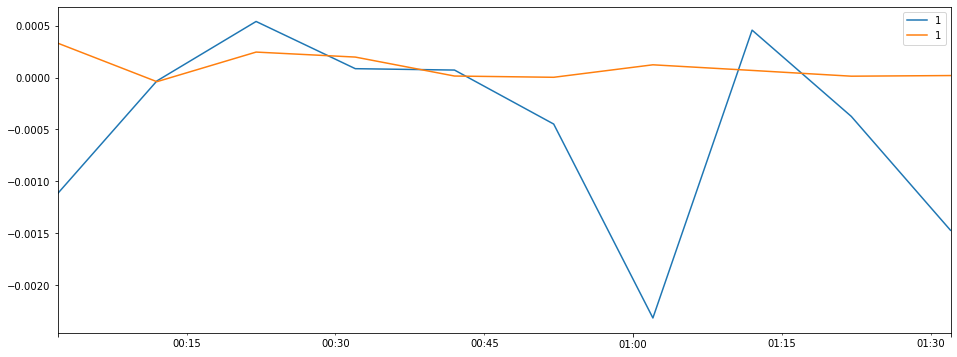

In [214]:
plt_df = pd.concat([dta_log_pr.iloc[1440*4:1440*4+100:10,1], point_forecasts[1]], axis=1)

# plt_df['fore'] = point_forecasts[1]

plt_df.plot(figsize=(16,6))


# Prediction Model

In [199]:
plt_df


timestamp
2021-07-05 00:02:00                                            -0.001117
2021-07-05 00:12:00                                            -0.000033
2021-07-05 00:22:00                                              0.00054
2021-07-05 00:32:00                                             0.000085
fore                   2021-07-05 00:02:00    0.000333
2021-07-05 00:...
Name: 1, dtype: object

# get_r_hat function

In [97]:
# An example of get_r_hat

def get_r_hat(A, B): 
    """
        A: 1440-by-10 dataframe of log prices with columns log_pr_0, ... , log_pr_9
        B: 1440-by-10 dataframe of trading volumes with columns volu_0, ... , volu_9    
        return: a numpy array of length 10, corresponding to the predictions for the forward 30-minutes returns of assets 0, 1, 2, ..., 9
    """
    
    return -(A.iloc[-1] - A.iloc[-30]).values # Use the negative 30-minutes backward log-returns to predict the 30-minutes forward log-returns

In [98]:
# Generate r_hat every 10 minutes

t0 = time.time()
dt = datetime.timedelta(days=1)
r_hat = pd.DataFrame(index=log_pr.index[30::10], columns=np.arange(10), dtype=np.float64)
for t in log_pr.index[30::10]: # compute the predictions every 10 minutes
    r_hat.loc[t, :] = get_r_hat(log_pr.loc[(t - dt):t], volu.loc[(t - dt):t])
t_used = time.time() - t0
print(t_used)
    

5.004619836807251


In [101]:
r_hat

,0,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,,
2021-07-01 00:31:00,0.004191,3.039331e-03,0.000937,-0.000282,-0.004850,0.000776,-0.003554,-0.001533,0.003916,0.000947
2021-07-01 00:41:00,-0.000561,1.700450e-03,0.000213,-0.000423,0.000678,-0.000073,-0.000904,0.000299,-0.000614,-0.000080
2021-07-01 00:51:00,0.000553,5.917961e-06,0.000013,0.000112,-0.000172,-0.000009,-0.000305,-0.000490,0.000022,-0.000199
2021-07-01 01:01:00,-0.001568,-2.172452e-04,0.000624,0.001704,0.000630,0.000503,0.000421,0.000347,0.000738,0.000539
2021-07-01 01:11:00,0.000049,-4.548799e-04,0.000608,-0.000924,0.000315,-0.000493,-0.000756,0.000196,0.000165,-0.000409
...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:11:00,0.000193,-2.120093e-07,-0.002032,0.000453,-0.000714,0.000843,0.000121,0.000493,-0.000185,0.000216
2021-12-31 23:21:00,0.000958,-3.709160e-04,-0.001272,-0.001159,-0.000540,-0.000402,0.000494,-0.000087,0.000523,0.000816
2021-12-31 23:31:00,0.004356,-7.759880e-05,0.005139,-0.001485,-0.000726,-0.000942,-0.000025,-0.000939,-0.000793,-0.000696


In [25]:
# Compute true forward log_returns every 10 minutes
r_fwd = (log_pr.shift(-30) - log_pr).iloc[30::10].rename(columns={f"log_pr_{i}": i for i in range(10)})


In [26]:
# Correlation for every asset

r_fwd.corrwith(r_hat)

0    0.028584
1    0.063681
2    0.005824
3    0.036314
4    0.096442
5    0.035261
6    0.067607
7    0.022329
8    0.105946
9    0.053176
dtype: float64

In [27]:
# Overall correlation (The ranking is based on this metric on the testing dataset)

r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
r_hat_all = r_hat.iloc[:-3].values.ravel()
np.corrcoef(r_fwd_all, r_hat_all)[0, 1]

0.040118694541047606